In [1]:
import torch
import torch.nn as nn
import torch.nn.init as init
from torch.utils.data import TensorDataset, DataLoader
from torchviz import make_dot
from torchsummary import summary

import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib

from sklearn import svm
from sklearn.model_selection import train_test_split

import glob
import os
import time
import sys
from tqdm.notebook import tqdm
import wandb

sys.path.append("/home/filament/fujimoto/Cygnus-X_CAE/Cygnus-X_cloud")
from models import model_layer9_BatchNorm_no_center as model

In [2]:
import os
print(os.getcwd())

/home/filament/fujimoto/Cygnus-X_CAE/analysis/check_model


In [3]:
class DataSet():
    def __init__(self, data, label):
        self.label = label
        self.data = data
        
    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, index):
        return self.data[index], self.label[index]

In [4]:
api = wandb.Api()
artifact_path = 'yudai22-/condition_matching/training_log:v3'
artifact = api.artifact(artifact_path)
artifact_dir = artifact.download()

print("Downloaded to:", artifact_dir)

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Using wandb-core as the SDK backend.  Please refer to https://wandb.me/wandb-core for more information.
wandb: Downloading large artifact training_log:v3, 67.62MB. 1 files... 
wandb:   1 of 1 files downloaded.  
Done. 0:0:0.4


Downloaded to: /home/filament/fujimoto/Cygnus-X_CAE/analysis/check_model/artifacts/training_log:v3


In [5]:
run = artifact.logged_by()
latent = run.config["latent_num"]
print(latent)

weight_path = f"{artifact_dir}/model_parameter.pth"
weight_para = torch.load(weight_path, map_location=torch.device('cpu'))

100


/tmp/ipykernel_26864/1178402748.py:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  weight_para = torch.load(weight_path, map_location=torch.device('cpu'))


In [6]:
model = model.Conv3dAutoencoder(latent)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu') 

In [7]:
model.load_state_dict(weight_para)
model.to("cpu")
model.eval()

Conv3dAutoencoder(
  (encoder): Sequential(
    (0): Conv3d(1, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (1): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv3d(32, 32, kernel_size=(4, 4, 4), stride=(2, 2, 2), padding=(1, 1, 1))
    (4): BatchNorm3d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): Conv3d(32, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (7): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (8): ReLU(inplace=True)
    (9): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1))
    (10): ReLU(inplace=True)
    (11): Conv3d(64, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1))
    (12): ReLU(inplace=True)
    (13): Flatten(start_dim=1, end_dim=-1)
    (14): Linear(in_features=84640, out_features=100, bias=True)
  )
  (decoder): Sequential(
    (0): 

In [8]:
summary(model.to(device), (1, 30, 100, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv3d-1       [-1, 32, 15, 50, 50]           2,080
       BatchNorm3d-2       [-1, 32, 15, 50, 50]              64
              ReLU-3       [-1, 32, 15, 50, 50]               0
            Conv3d-4        [-1, 32, 7, 25, 25]          65,568
       BatchNorm3d-5        [-1, 32, 7, 25, 25]              64
              ReLU-6        [-1, 32, 7, 25, 25]               0
            Conv3d-7        [-1, 64, 7, 25, 25]          55,360
       BatchNorm3d-8        [-1, 64, 7, 25, 25]             128
              ReLU-9        [-1, 64, 7, 25, 25]               0
           Conv3d-10        [-1, 64, 7, 25, 25]         110,656
             ReLU-11        [-1, 64, 7, 25, 25]               0
           Conv3d-12        [-1, 32, 5, 23, 23]          55,328
             ReLU-13        [-1, 32, 5, 23, 23]               0
          Flatten-14                [-1

In [9]:
data = np.load("/home/filament/fujimoto/Cygnus-X_CAE/data/zroing_resize_data/resize_data/condition_match/vflip/CygnusX_bubble_vflip.npy")
# data = np.load("/home/cygnus/FUGIN_CAE_projects/FUGIN_CAE/120_layers/data/cygnusX_layer120_merged_data_flip.npy")
print(len(data))
data = torch.from_numpy(data).float()
# data = data[:, None, :, :, :]
label = [0]*len(data)

# train_data, val_data, train_labels, val_labels = train_test_split(data, label, test_size=0.2, random_state=42, stratify=label)
# val_data, test_data, val_labels, test_labels = train_test_split(val_data, val_labels, test_size=0.25, random_state=42, stratify=val_labels)
# train_dataset = DataSet(train_data, train_labels)
# train_dataloader = DataLoader(train_dataset, batch_size=args.train_mini_batch, shuffle=True)
# val_dataset = DataSet(val_data, val_labels)
# val_dataloader = DataLoader(val_dataset, batch_size=args.val_mini_batch, shuffle=False)
test_dataset = DataSet(data, label)
test_dataloader = DataLoader(test_dataset, batch_size=33, shuffle=False)

31


In [10]:
print(test_dataset[0][0].shape)

torch.Size([30, 100, 100])


In [11]:
import re

match = re.findall('/.*/', artifact_path)
log_name = artifact_path.split("/")[-1]

print(log_name)
print(match[0][1:-1])

if os.path.exists(f"./saved_pictures/{match[0][1:-1]}/{log_name}_output_images/bubble"):
    pass
else:
    os.makedirs(f"./saved_pictures/{match[0][1:-1]}/{log_name}_output_images/bubble")

training_log:v3
condition_matching


In [12]:
model.to("cpu")

output_list = []
for images, labels in tqdm(test_dataloader):
    images = images.view(-1, 1, 30, 100, 100)  # バッチサイズを維持したままチャンネル数を1に設定
    with torch.set_grad_enabled(True):
            
        # モデルの出力を計算する
        output = model(images.clone().to("cpu"))
        output = output.squeeze()
        output_list.append(output.to("cpu").detach().numpy().copy())

  0%|          | 0/1 [00:00<?, ?it/s]

In [13]:
output_list = np.concatenate(output_list)

In [14]:
print(len(output_list))
print(len(data))

31
31


In [15]:
num_index = np.random.choice(len(output_list[0]), 5)
num_index = list(num_index)
num_index.sort()
print(num_index)

[7, 9, 11, 22, 29]


In [16]:
num_index = [0, 4, 8, 17, 28]

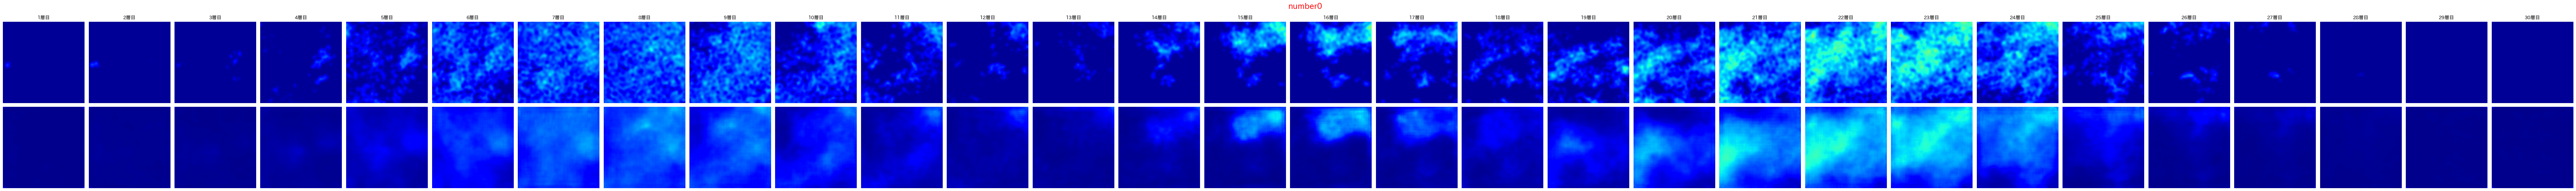

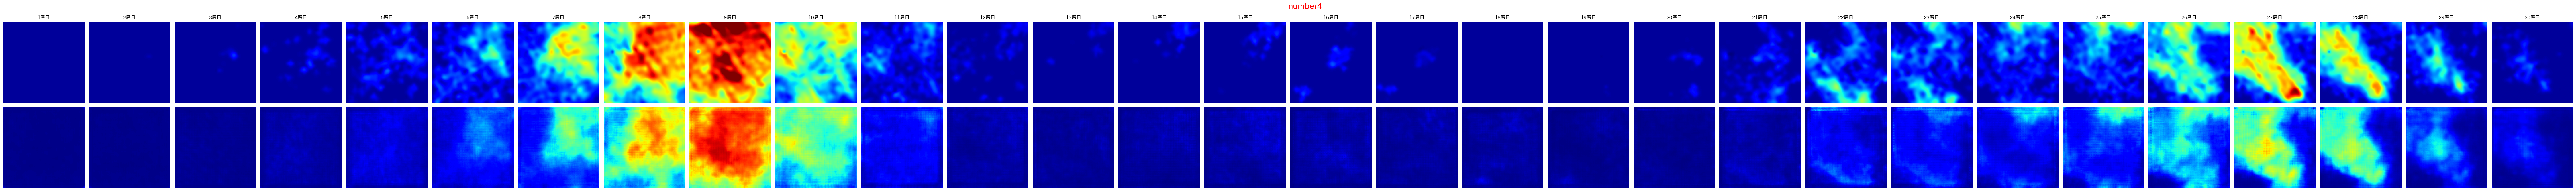

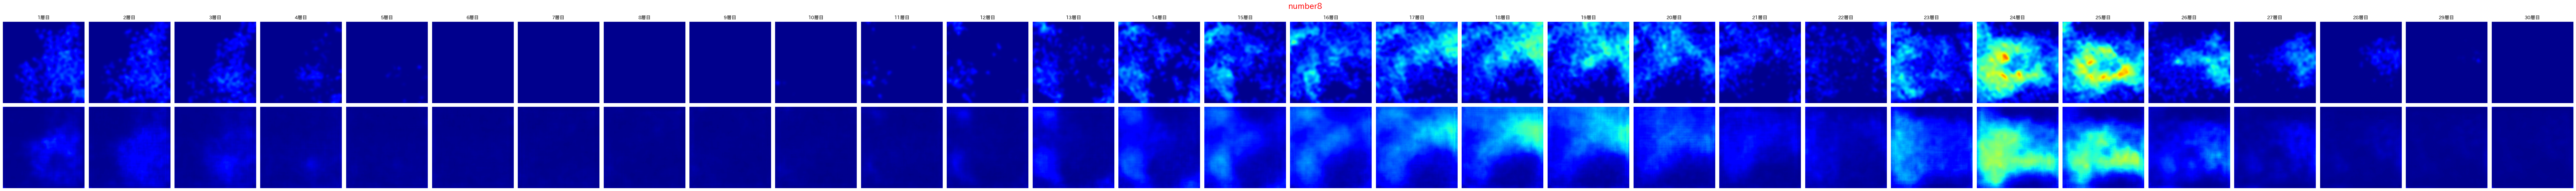

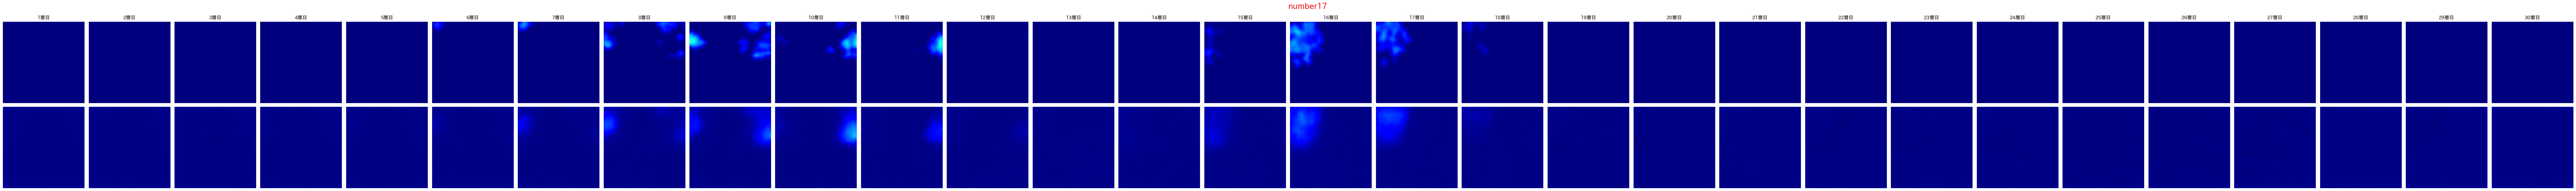

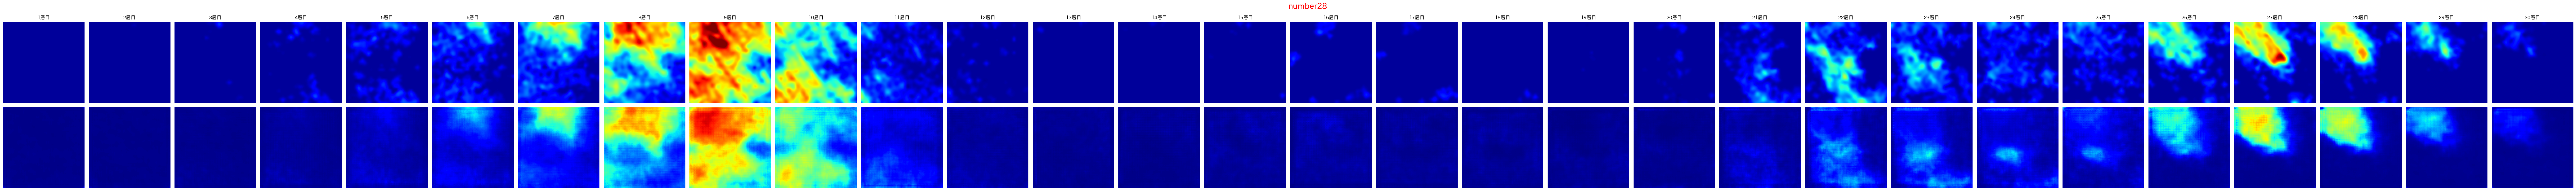

In [17]:
for i in num_index:
    image1 = data[i]
    image2 = output_list[i]

    fig, axes = plt.subplots(2, 30, figsize=(3*30, 7))
    for j in range(len(image1)):
        axes[0, j].imshow(image1[j, :, :], vmin=0, vmax=1, cmap="jet")
        axes[0, j].axis('off')
        axes[0, j].set_title(f"{j+1}層目")
    
        axes[1, j].imshow(image2[j, :, :], vmin=0, vmax=1, cmap="jet")
        axes[1, j].axis('off')

    fig.suptitle(f"number{i}", x=0.5, y=0.98, ha='left', fontsize=20, color="r")
    plt.tight_layout()
    plt.savefig(f"./saved_pictures/{match[0][1:-1]}/{log_name}_output_images/bubble/{log_name}_出力結果{i}.png", format="png", dpi=50)
    plt.show()

In [18]:
# for i in range(len(data)):
#     image1 = data[i].numpy()
#     image1 = np.sum(image1, axis=0)
#     image2 = output_list[i]
#     image2 = np.sum(image2, axis=0)
#     images = [image1, image2]


#     fig, axes = plt.subplots(1, 2, figsize=(3*6, 7))
#     for j in range(len(images)):
#         axes[j].imshow(images[j], cmap="viridis")
#         axes[j].axis('off')

#     fig.suptitle(f"number{i}", x=0.5, y=0.98, ha='left', fontsize=20, color="r")
#     # plt.tight_layout()
#     plt.savefig(f"{match[0][1:-1]}/{log_name}_output_images/bubble/{log_name}_出力結果_sum{i}.png", format="png", dpi=50)
#     # plt.show()

In [19]:
latent_save_dir = f"/home/filament/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/{match[0][1:-1]}/bubble"
print(latent_save_dir)

if os.path.exists(latent_save_dir):
    pass
else:
    os.makedirs(latent_save_dir)

/home/filament/fujimoto/Cygnus-X_CAE/analysis/check_latent/latent_list/condition_matching/bubble


In [20]:
# CAEのエンコーダ部分から潜在変数を抽出する
latent_list = []
for images, labels in test_dataloader:
    # 画像をモデルに入力するために正しいデバイスに移す
    images = images.view(-1, 1, 30, 100, 100)
    images = images.to("cpu")

    with torch.no_grad():  # 勾配計算は不要
        # エンコーダ部分のみの出力を取得（潜在変数）
        latent_output = model.encoder(images)

        # 潜在変数をリストに追加 (CPUに戻し、numpy形式に変換)
        latent_list.append(latent_output.cpu().detach().numpy())

# 潜在変数のリストを1つの配列に結合
latent_array = np.concatenate(latent_list, axis=0)
np.save(f"{latent_save_dir}/{log_name}_bubble_latent.npy", latent_array)

In [21]:
latent_array.shape

(31, 100)